# Deep Learning
### Week 10: Variational autoencoder

## Contents

[1. Introduction](#introduction)

[2. Autoencoders](#autoencoders)

[3. CNN Autoencoder Example (\*)](#cnn_autoencoder_example)

[4. The variational autoencoder](#vae)

[5. Probabilistic layers (\*)](#probabilisticlayers)

[6. The KLDivergenceAddLoss layer (\*)](#kldivlayer)

[7. Improved posterior approximation with IAF](#iaf)

[References](#references)

<a class="anchor" id="introduction"></a>
## Introduction

In the last weeks of the module we saw how the TensorFlow Probability library can be used to develop normalising flow probabilistic deep learning models. These types of models use two of the core objects in the TFP library: `Distribution` and `Bijector` objects. 

You learned about autoregressive flows such as the masked autoregressive flow (MAF), NICE and RealNVP, and saw how these flows can be built and trained using pre-defined bijectors in TFP, or with bijector subclassing. 

In this week of the module, we will look at another important deep learning algorithm: the variational autoencoder, or VAE. The VAE is an algorithm for inference and learning in a latent variable generative model. It has been successfully applied in a variety of application domains, such as neuroimaging ([Benou et al 2016](#Benou16)), drug discovery ([Jin et al 2018](#Jin18)), anomaly detection ([Xu et al 2018](#Xu18)) and music generation ([Dhariwal et al 2020](#Dhariwal20)).

In its simplest form, the VAE is an unsupervised learning algorithm, and like normalising flows, the generative model can be used to create new examples similar to the dataset. However, unlike normalising flows, the generative model is not invertible, and so it's not as straightforward to train the model using maximum likelihood.

The VAE uses the principle of variational inference to approximate the posterior distribution, by defining a parameterised family of distributions conditioned on a data example, and then maximising a lower bound on the marginal likelihood. This is the evidence lower bound, or ELBO.

In this week, we'll build up the pieces we need to implement a variational autoencoder with TensorFlow and TensorFlow Probability, starting with looking at building regular autoencoder architectures. In addition to the tools we have already looked at, we will be making use of probabilistic layers, which are found in the `layers` module of TFP.

We will see that a key challenge in the variational autoencoder is the approximation of the true posterior distribution. In the final part of the week we will take a look at one method to improve this approximation, making use of normalising flows.

<a class="anchor" id="autoencoders"></a>
## Autoencoders

In this section, we'll look at how to implement a standard autoencoder architecture. 

An autoencoder can be viewed as a compression algorithm, similar to a VAE, although it's not a probabilistic model, and it is not a model of the underlying data distribution.

The aim of an autoencoder is to learn an efficient data encoding. The network is normally trained in an unsupervised manner, and the task of the network is to reproduce its input as its output. 

<img src="figures/autoencoder.png" alt="Autoencoder network" style="width: 750px;"/>
<center>An autoencoder network architecture, with bottleneck latent variable $\mathbf{z}$</center>

The autoencoder has a bottleneck architecture as in the above figure, and can be broken into two parts: the **encoder** network and the **decoder** network. In the middle of the bottleneck is the latent variable $\mathbf{z}$, which captures the encoding of the data. The dimensionality of $\mathbf{z}$ is typically much lower than the data $\mathbf{x}$, and so the network is trained to perform nonlinear dimension reduction ([Kramer 1991](#Kramer91)). The job of the encoder is to learn an efficient representation of the data in a much lower dimensional encoding space, whilst the decoder is required to decompress the latent code to reconstruct the data input $\mathbf{x}$.

For an autoencoder network $f_{\mathbf{\theta}}$, the model is trained to minimise the loss

$$
L(\theta; \mathcal{D}_{train}) = \frac{1}{|\mathcal{D}_{train}|}\sum_{x_i\in\mathcal{D}_{train}}l(x_i, f_\theta(x_i)),
$$

where $l: \mathbb{R}^D\times \mathbb{R}^D\mapsto\mathbb{R}$ is a suitable loss function, such as mean squared error. In practice, the model is trained using minibatches of data as usual.

There are several variants of the autoencoder model, one notable example being the **denoising autoencoder** ([Vincent & Larochelle 2010](#Vincent10)). In this model, the input $\mathbf{x}$ is corrupted with noise to produce the input $\tilde{\mathbf{x}}$, and the model is trained to minimise the loss

$$
L(\theta; \mathcal{D}_{train}) = \frac{1}{|\mathcal{D}_{train}|}\sum_{x_i\in\mathcal{D}_{train}}l(x_i, f_\theta(\tilde{x}_i)).
$$

In other words, the model is tasked to clean the corrupted input by encoding it into a suitable representation. Intuitively, this is motivated by the idea that good representations should be robust to the corruption of the input $\mathbf{x}$, and that to denoise the input successfully, the model needs to extract features that capture useful structure in the distribution of the input, and ignore features in the data that are unimportant.

The noise is typically injected stochastically during the training run, according to a prescribed distribution $q(\tilde{\mathbf{x}} \mid \mathbf{x})$, so that the noise is different on each epoch.

There's nothing in our assumptions here or the way we've built the autoencoder that implies there's any specific structure to the latent space. Probably the autoencoder will learn to cluster similar examples together. But the way it organizes those clusters collectively is mostly arbitrary. It isn't necessarily meaningful to try to interpolate between latent encodings of data samples or another way of saying that is that we're not training the autoencoder to learn the underlying data manifold. It's free to use the latent space in any way at once, which potentially could be quite unstructured. Sampling or random point from the latent space and decoding it won't necessarily produce anything coherent.(contrast to VAE)

<a class="anchor" id="cnn_autoencoder_example"></a>
## CNN Autoencoder Example

In this section, we will implement a CNN autoencoder for the Fashion-MNIST dataset, and examine the learned encodings.

In [1]:
import tensorflow as tf

The Fashion-MNIST dataset can be loaded with the Keras API.

In [2]:
# Load the dataset, rescale

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.

In [3]:
# Store the class names

import numpy as np

class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])

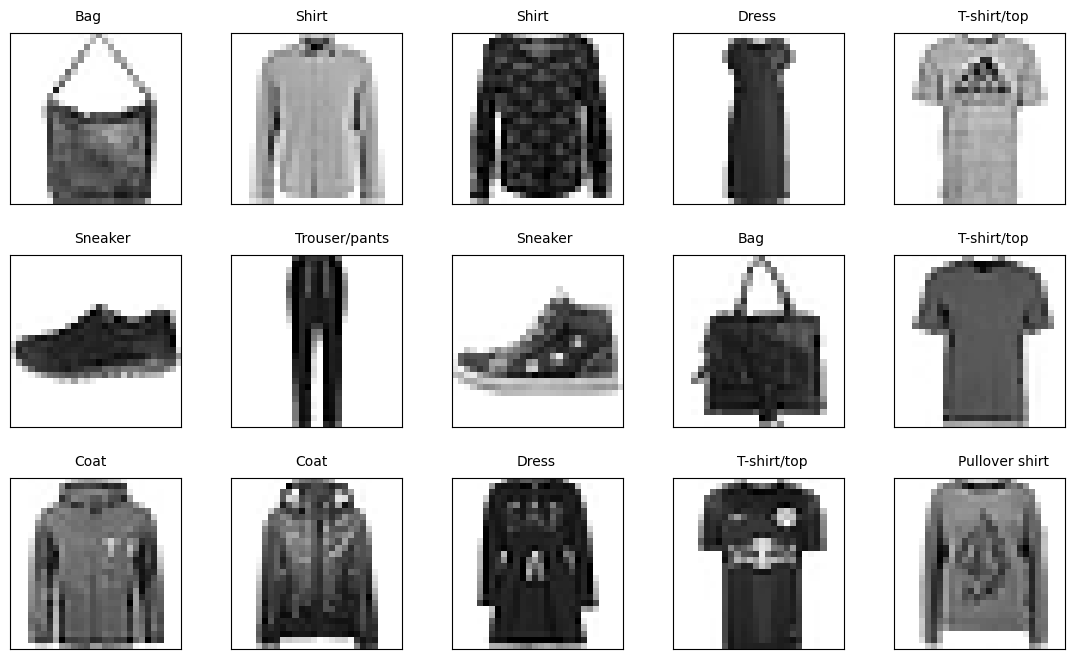

In [4]:
# Display a few examples

import matplotlib.pyplot as plt

n_rows, n_cols = 3, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
inx = np.random.choice(x_train.shape[0], n_rows*n_cols, replace=False)
fig.subplots_adjust(hspace=0.3, wspace=0.1)

for n, (image, label) in enumerate(zip(x_train[inx], y_train[inx])):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(image, cmap='binary')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(10., -2.5, f'{class_names[label]}')
plt.show()

#### Build the CNN autoencoder model
We define the encoder and decoder networks separately.

In [7]:
# Build a CNN encoder

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

encoded_dim = 2

cnn_encoder = Sequential([
    Conv2D(16,5,activation = "relu", input_shape = (28,28,1)),
    MaxPool2D(2),
    Conv2D(8,5,activation = "relu"),
    Flatten(),
    Dense(64,activation = "relu"),
    Dense(encoded_dim)
])

cnn_encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 16)        416       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 8)           3208      
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                      

In [8]:
# Compute encodings before training
inx = np.random.choice(x_test.shape[0],1000,replace = False)
untrained_encodings = cnn_encoder(x_test).numpy()
untrained_encodings_labels = y_test[inx]

C:\Users\frase\AppData\Local\Temp\ipykernel_15200\3532246818.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 10)


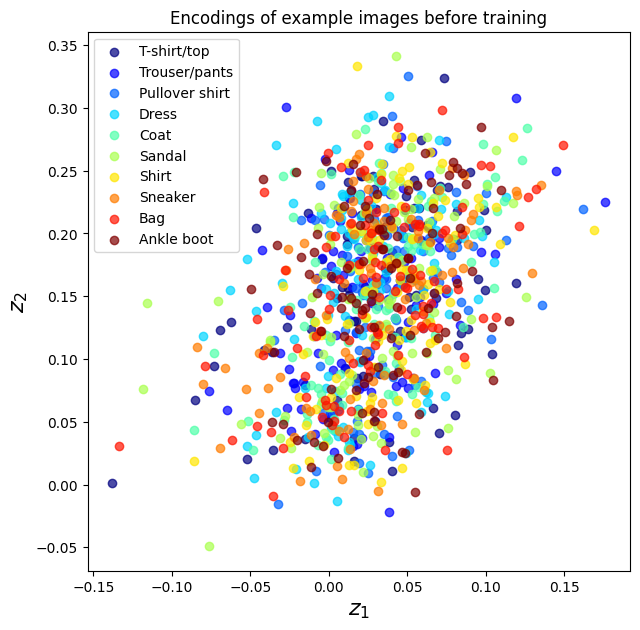

In [9]:
# Plot untrained encodings

from matplotlib import cm

plt.figure(figsize=(7, 7))
cmap = cm.get_cmap('jet', 10)
for i, class_label in enumerate(class_names):
    inx = np.where(untrained_encodings_labels == i)[0]
    plt.scatter(untrained_encodings[inx, 0], untrained_encodings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images before training')
plt.legend()
plt.show()

In [12]:
# Build a CNN decoder

from keras.layers import Reshape, UpSampling2D, Conv2DTranspose
#build so it is opposite as encoder as much as possible

cnn_decoder = Sequential([
    Dense(64, activation = "relu", input_shape = (encoded_dim,)),
    Dense(512, activation = "relu"),
    #opposite of flatten
    Reshape((8,8,8)), #height and width of 8 and 8 channels
    Conv2DTranspose(16,5,activation = "relu"),
    #approx inverse of max pooling:
    UpSampling2D((2,2)),
    #output same dimension as input, sigmoid so in 0,1
    Conv2DTranspose(1,5,activation = "sigmoid")
])

cnn_decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                192       
                                                                 
 dense_9 (Dense)             (None, 512)               33280     
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 8)           0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 12, 12, 16)       3216      
 ranspose)                                                       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 1)       

In [17]:
# Define the autoencoder

from keras.models import Model

#input is input tensor for encoder, output is output of connected decoder
cnn_autoencoder = Model(inputs  = cnn_encoder.input,outputs = cnn_decoder(cnn_encoder.output))

#### Make train and test Datasets

In [18]:
# Create Dataset objects for train and test sets

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test))

In [19]:
# Process the datasets

train_dataset = train_dataset.shuffle(1000)

train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [21]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
# Compile and fit the model

#could use mse but the assumption of bernoulli works better
cnn_autoencoder.compile(loss='binary_crossentropy')
cnn_autoencoder.fit(train_dataset, epochs=10)

Epoch 1/10
938/938 [==============================] - 7s 5ms/step - loss: 0.3963
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3480
Epoch 3/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3397
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.3359
Epoch 5/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3335
Epoch 6/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3317
Epoch 7/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3303
Epoch 8/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3293
Epoch 9/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3284
Epoch 10/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3277


In [22]:
# Compute encodings after training

inx = np.random.choice(x_test.shape[0], 1000, replace=False)
trained_encodings = cnn_encoder(x_test[inx]).numpy()
trained_encoding_labels = y_test[inx]


C:\Users\frase\AppData\Local\Temp\ipykernel_15200\3507586267.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 10)


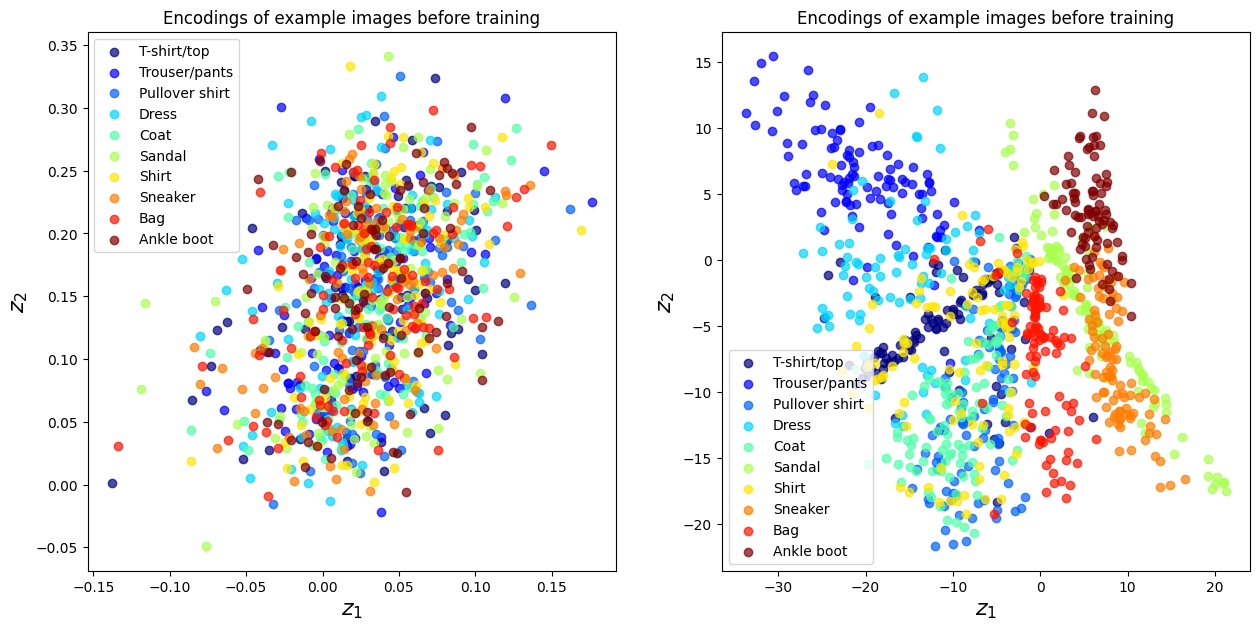

In [24]:
# Plot untrained and trained encodings

from matplotlib import cm

plt.figure(figsize=(15, 7))
cmap = cm.get_cmap('jet', 10)

plt.subplot(1, 2, 1)
for i, class_label in enumerate(class_names):
    inx = np.where(untrained_encodings_labels == i)[0]
    plt.scatter(untrained_encodings[inx, 0], untrained_encodings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images before training')
plt.legend()

plt.subplot(1, 2, 2)
for i, class_label in enumerate(class_names):
    inx = np.where(trained_encoding_labels == i)[0]
    plt.scatter(trained_encodings[inx, 0], trained_encodings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images before training')
plt.legend()

plt.show()

### MUCH MORE STRUCTURE ###

In [25]:
# Compute the autoencoder's reconstructions

inx = np.random.choice(x_test.shape[0], 5, replace=False)
reconstructed_example_images = cnn_autoencoder(x_test[inx])


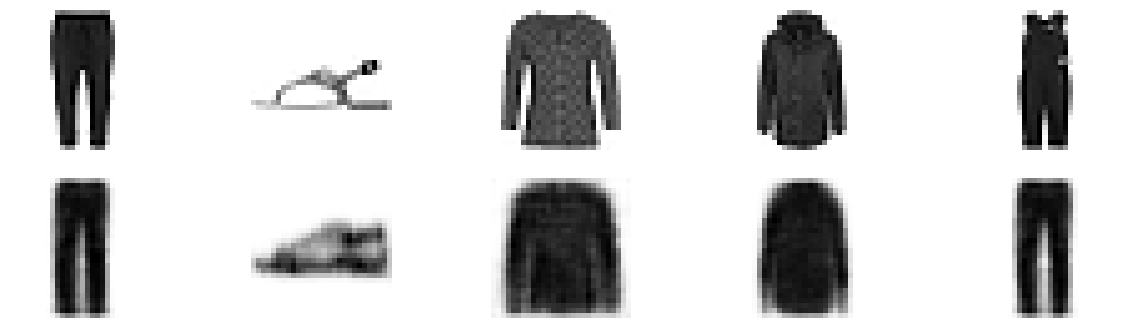

In [26]:
# Evaluate the autoencoder's reconstructions

f, axs = plt.subplots(2, 5, figsize=(15, 4))
for j in range(5):
    axs[0, j].imshow(x_test[inx][j], cmap='binary')
    axs[1, j].imshow(reconstructed_example_images[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

_Exercise._ Redesign the CNN autoencoder above using strides $\ge2$ for the encoder, and design the decoder to be the reverse architecture.

<a class="anchor" id="vae"></a>
## The variational autoencoder

We will now review the variational autoencoder (VAE) algorithm, its derivation from applying the principle of variational inference to a prescribed generative model, and its connection to standard autoencoders. The VAE was developed independently by [Kingma & Welling 2014](#Kingma14) and [Rezende et al 2014](#Rezende14) at about the same time. For a general reference on variational inference, see [Blei et al 2017](#Blei17).

First, we describe the generative model behind the variational autoencoder. This is a **latent variable generative model**, where we introduce a latent (unobserved) random variable that is intended to capture hidden causes or explanations of the data. 

Furthermore, it is a **prescribed model** in the sense that we prescribe a noise model for the observations. Given a latent variable ${z}\in\mathbb{R}^l$, this determines a distribution over possible observations $p_\theta({x} \mid {z})$, with $x\in\mathbb{R}^D$. This class of generative model is also called a **likelihood-based model**, since the observations have an associated likelihood function. 

This is in contrast to an **implicit model**, where there is no likelihood function on the observations, and instead a realisation of the latent variable ${z}$ implicitly defines the observation ${x}$ (note that this is the case with normalising flows, although there we have the additional special structure that the generative model is invertible, and so the observation likelihood can still be explicitly computed). This is illustrated in the following figure.

<img src="figures/generative_models.png" alt="Generative models" style="width: 400px;"/>
<center>Latent variable directed graphical models; (a) a prescribed generative model that defines a likelihood for each observation, and (b) an implicit generative model. The VAE is based on the prescribed model</center>

The generative model under consideration can be written as $p_\theta({z})p_\theta({x} \mid {z})$, where the conditional distribution $p_\theta({x} \mid {z})$ is defined by a neural network. The **marginal likelihood** (or **model evidence**) of an individual datapoint $x\in\mathbb{R}^D$ is given by

$$
p_\theta({x}) = \int p_\theta({z})p_\theta({x} \mid {z}) d{z},\tag{1}
$$

where $\theta$ are the model parameters. 

Note that under the usual i.i.d. assumption of our dataset $\mathbf{x} = (x_i)_{i=1}^N$,  the full data log-likelihood is given by

$$
\log p_\theta(\mathbf{x}) = \sum_{i=1}^N \log p_\theta(x_i).
$$

In the following we will continue to consider the likelihood of a single datapoint $x_i$, and drop the subscript $i$ for notational convenience.

Now, we would like to choose the parameters $\theta$ that maximise the marginal likelihood. Unfortunately, the integral above is intractable in general (as is the true posterior $p({z} \mid {x})$), so we need to approximate it.

The approximation that we will use is the **evidence lower bound** (ELBO), or **variational free energy**, which is a lower bound on the true marginal log-likelihood:

$$
\begin{align}
\log p_\theta({x}) &\ge \mathbb{E}_{q_\phi({z}\mid{x})} \left[ \log p_\theta({x}\mid{z})\right] - D_{KL}\left( q_\phi({z}\mid{x}) || p_\theta({z}) \right)\tag{2}\\
&=: \mathcal{L}(\theta, \phi; {x}), 
\end{align}
$$

where $q_\phi({z} \mid {x})$ is a parameterised distribution of our choosing, and $D_{KL}$ denotes the Kullback-Leibler divergence, given by

$$
D_{KL}\left( q_\phi({z}\mid{x}) || p_\theta({z}) \right) = \int q_\phi({z}\mid{x})\log\left(\frac{q_\phi({z}\mid{x})}{p_\theta({z})}\right)d{z}.
$$

The two terms in \eqref{elbo} are often interpreted as a reconstruction loss term and a regularisation term:

$$
\mathcal{L}(\theta, \phi; {x}) = \underbrace{\mathbb{E}_{q_\phi({z}\mid{x})} \left[ \log p_\theta({x}\mid{z})\right]}_{\text{reconstruction loss}} - \underbrace{D_{KL}\left( q_\phi({z}\mid{x}) || p_\theta({z}) \right)}_{\text{regulariser}}.
$$

This decomposition shows the connection to autoencoders: if $q_\phi({z}\mid{x})$ is a parameterised neural network, then we can view this as the encoder and $p_\theta({x}\mid{z})$ as the decoder. Then the reconstruction loss is the probabilistic version of the autoencoder reconstruction loss (where we could consider $q_\phi({z}\mid{x})$ as a delta distribution). The second term regularises the encoder, and ensures it doesn't stray too far from the prior distribution $p_\theta({z})$.

The ELBO is also sometimes written as $\mathcal{L}(\theta, \phi; {x}) = \mathbb{E}_{q_\phi({z}\mid {x})}\left[ -\log q_\phi({z}\mid{x}) + \log p_\theta({x}, {z}) \right]$.

#### Derivation of the ELBO
We will derive the evidence lower bound in two different ways. The first is a simple derivation using Jensen's inequality, and the second will help to shed some light on the optimal choice for the distribution $q_\phi({z} \mid {x})$.

_Derivation 1_. The marginal log-likelihood is given by (cf. \eqref{evidence})

$$
\begin{align}
\log p_\theta({x}) &= \log\int p_\theta({x}\mid{z})p_\theta({z})d{z}\\
&= \log \int p_\theta({x}\mid{z})\frac{p_\theta({z})}{q_\phi({z}\mid{x})}q_\phi({z}\mid{x})d{z}\\
&\ge \int\log\left(p_\theta({x}\mid {z})\frac{p_\theta({z})}{q_\phi({z}\mid {x})}\right)q_\phi({z}\mid {x})d{z}\\
&= \int q_\phi({z}\mid {x}) \log p_\theta({x}\mid {z})d{z} - \int q_\phi({z}\mid {x}) \log \left(\frac{q_\phi({z}\mid {x})}{p_\theta({z})}\right)d{z}\\
&= \mathcal{L}(\theta, \phi; {x}),
\end{align}
$$

where the third line in the above uses Jensen's inequality.

_Derivation 2._ Let $q_\phi({z}\mid {x})$ be a parameterised family of distributions that we use to approximate the true posterior $p_\theta({z}\mid {x})$. We define the objective function that we wish to minimise as the KL-divergence $D_{KL}(q_\phi({z}\mid {x}) || p_\theta({z}\mid {x}))$. Then we have

$$
\begin{align}
D_{KL}(q_\phi({z}\mid {x}) || p_\theta( {z}\mid {x})) &= \int q_\phi({z}\mid {x}) \log\left(\frac{q_\phi({z}\mid {x})}{p_\theta({z}\mid {x})}\right) d{z}\\
&= \int q_\phi({z}\mid {x}) \log\left( \frac{q_\phi({z}\mid {x}) p_\theta({x})}{p_\theta({x}\mid{z})p_\theta({z})}\right) d{z}\\
&= \int q_\phi({z}\mid {x}) \log p_\theta({x}) d{z} - \int q_\phi({z}\mid{x}) \log p_\theta({x}\mid{z})d{z}\\
& \quad + \int q_\phi({z}\mid {x})\log\left( \frac{q_\phi({z}\mid {x})}{p_\theta({z})}  \right)d{z}\\
&= \log p_\theta({x}) - \mathcal{L}(\theta, \phi; {x})
\end{align}
$$

Since the KL-divergence is always non-negative, the above shows that $\mathcal{L}(\theta, \phi; {x})$ is indeed a lower bound on the marginal log-likelihood $\log p_\theta({x})$. Furthermore, it shows that the gap in the bound is given by $D_{KL}(q_\phi({z}\mid {x}) || p_\theta({z}\mid {x}))$. 

We see that to maximise the ELBO, the distribution $q_\phi({z}\mid {x})$ should approximate the true posterior $p_\theta({z}\mid {x}))$. And the better the approximation, the tighter the bound.

The following figure illustrates that the variational autoencoder adds the variational approximation $q_\phi({z}\mid {x})$ to the intractable true posterior $p_\theta({z}\mid {x}))$. 

<img src="figures/generative_variational.png" alt="The generative model and variational approximation to the true posterior" style="width: 250px;"/>
<center>The prescribed generative model underlying the variational autoencoder, and the variational approximation $q_\phi({z}\mid {x})$ with variational parameters $\phi$ depicted with dashed lines</center>

Note that the generative model parameters $\theta$ and the variational parameters $\phi$ are **global variables**, whereas the latent random variable ${z}$ is a **local variable**. The variational parameters $\phi$ are shared across all data points, and are not specific to individual data points, in contrast to traditional mean-field variational inference. This strategy is known as **amortized inference** ([Hoffman et al 2013](#Hoffman13)).

#### The reparameterization trick
We have now defined our ELBO objective function that we wish to maximise, which is a lower bound on the marginal log-likelihood:

$$
\mathcal{L}(\theta, \phi; {x}) = 
 \mathbb{E}_{q_\phi({z}\mid {x})} \left[ \log p_\theta({x}\mid {z})\right] - D_{KL}\left( q_\phi({z}\mid {x}) || p_\theta({z}) \right)
$$

Note that we are able to evaluate the densities $q_\phi({z}\mid{x})$, $p_\theta({x}\mid{z})$, $p_\theta({z})$ as well as sample from the approximating distribution $q_\phi({z}\mid {x})$, so the ELBO can be evaluated using Monte Carlo samples $\{z^{(j)}\}_{j=1}^L$, with $z^{(j)}$ sampled from $q_\phi({z}\mid{x})$

$$
\mathcal{L}(\theta, \phi; {x}) \approx \frac{1}{L} \sum_{j=1}^L \log p_\theta(x\mid z^{(j)}) + \log p_\theta(z^{(j)}) − \log q_\phi(z^{(j)}\mid x)
$$

The question remains how to optimise the ELBO with respect to the parameters $\theta$ and $\phi$. Note that taking gradients with respect to $\phi$ is not straightforward, as the $z^{(j)}$ are samples. 

A typical **score-function estimator** ([Glynn 1990](#Glynn90), [Kleijnen & Rubinstein 1996](#Kleijnen96)) for the general type of problem of taking a gradient of an expectation of some function $f(z)$ is given by

$$
\begin{align}
\nabla_\phi \mathbb{E}_{q_\phi(z)}\left[ f(z) \right] &= \mathbb{E}_{q_\phi(z)} \left[ f(z) \nabla_\phi \log q_\phi(z) \right]\\
&\approx \frac{1}{L} \sum_{j=1}^L \left[ f(z^{(j)}) \nabla_\phi \log q_\phi(z^{(j)}) \right].
\end{align}
$$

This estimator is also used in reinforcement learning for policy gradients, where it is often referred to as the REINFORCE algorithm ([Williams 1992](#Williams92)). However, this estimator typically has high variance ([Blei et al 2012](#Blei12)), and in our case we can do better, in particular since our function $f(z)$ $\left(=\log p_\theta(x, z^{(j)})  − \log q_\phi(z^{(j)}\mid x)\right)$ is differentiable.

The 'reparameterization trick' simply reparameterises the random latent variable $z\sim q_\phi(z\mid x)$ using a differentiable transformation $g_\phi(\epsilon, x)$ of an auxiliary noise variable $\epsilon\sim p(\epsilon)$:

$$
z \sim q_\phi(z\mid x)\\
z = g_\phi(\epsilon, x),\quad \epsilon\sim p(\epsilon)
$$

An example is if $q_\phi(z\mid x)$ a multivariate Gaussian distribution $N(\mu_\phi(x), \Sigma_\phi(x))$. Then we could reparameterise the distribution as 

$$
p(\epsilon)=N(\mathbf{0},\mathbf{I}),\quad g_\phi(\epsilon,x)=\mu_\phi(x)+L_\phi(x)\epsilon,\quad \text{where }L_\phi(x)L_\phi(x)^T =\Sigma_\phi(x).
$$

The encoder network would then output the distribution parameters $\mu_\phi(x)$ and $L_\phi(x)$, which are both fully differentiable with respect to $\phi$. Note that the noise variable distribution does not depend on any parameters. 

If the transformation $g_\phi(\cdot, x):\mathbb{R}^d\mapsto\mathbb{R}^l$ is invertible, this is nothing more than a change of variables, so the change of variables formula applies to give

$$
\begin{align}
q_\phi(z\mid x) &= \left|\, \det J_{g_\phi}(\epsilon)\,\right|^{-1}\cdot p(\epsilon)\\
&= \left|\, \frac{d\epsilon}{dz}\,\right|\cdot p(\epsilon)
\end{align}
$$

This leads to the **pathwise estimator** ([Devroye 1996](#Devroye96)), which for a general function $f(z)$ and reparameterization $g_\phi(\epsilon)$ is given by

$$
\begin{align}
\nabla_\phi \mathbb{E}_{q_\phi(z)}\left[ f(z) \right] &= \nabla_\phi \int {q_\phi(z)} f(z)dz\\
&= \nabla_\phi \int \left|\, \frac{d\epsilon}{dz}\,\right|\cdot p(\epsilon) f(g_\phi(\epsilon)) \left|\, \frac{dz}{d\epsilon}\,\right| d\epsilon\\
&= \nabla_\phi \mathbb{E}_{p(\epsilon)} \left[ f(g_\phi(\epsilon)) \right]\\
&=  \mathbb{E}_{p(\epsilon)} \left[ \nabla_\phi f(g_\phi(\epsilon)) \right]
\end{align}
$$

In our case, the reparameterization $g_\phi(\epsilon, x)$ and noise variable $\epsilon\sim p(\epsilon)$ leads to the **Stochastic Gradient Variational Bayes** (SGVB) estimator $\hat{\mathcal{L}}^A(\theta,\phi;x) \approx \mathcal{L}(\theta, \phi; {x})$:

$$
\hat{\mathcal{L}}^A(\theta,\phi;x) := \frac{1}{L} \sum_{j=1}^L \log p_\theta(x,z^{(j)})− \log q_\phi(z^{(j)}|x)\tag{3}\\
\text{where }z^{(j)} = g_\phi(\epsilon^{(j)}, x)\quad\text{and}\quad\epsilon^{(j)}\sim p(\epsilon)
$$

We can now use this estimator to approximate the ELBO objective, and take its gradients with respect to the parameters $(\theta, \phi)$ on minibatches of data to optimise them:

$$
\begin{align}
\mathbb{E}_{x\sim p_{data}}\left[ \log p_\theta(x)\right] &\approx \frac{1}{|\mathcal{D}_{train}|}\sum_{i\in\mathcal{D}_{train}} \log p_\theta(x_i)\\
&\ge \frac{1}{|\mathcal{D}_{train}|}\sum_{i\in\mathcal{D}_{train}} \mathcal{L}(\theta, \phi; {x_i})\\
&\approx \frac{1}{|\mathcal{D}_{train}|}\sum_{i\in\mathcal{D}_{train}} \hat{\mathcal{L}}^A(\theta,\phi;x)\\
&\approx \frac{1}{M} \sum_{i\in\mathcal{D}_{m}}  \hat{\mathcal{L}}^A(\theta,\phi;x),
\end{align}
$$

where as usual $\mathcal{D}_m$ is a randomly sampled minibatch of training data points, and $M=|\mathcal{D}_m|$. 

Note that we wish to maximise the above objective, so in practice we will take the negative of the quantity above to minimise.

Finally, depending on the choice of prior $p_\theta(z)$ and variational posterior $q_\phi(z\mid x)$, it may be possible to analytically evaluate the KL-divergence term $D_{KL}(q_\phi(z\mid x) || p_\theta(z))$. This is true, for example, in the case where both distributions are Gaussian. In this case, there is no need to approximate this term in the ELBO with Monte Carlo samples, and we can instead use the alternate version of the SGVB estimator:

$$
\hat{\mathcal{L}}^B(\theta,\phi;x) := \frac{1}{L} \sum_{j=1}^L \log p_\theta(x\mid z^{(j)}) − D_{KL}(q_\phi(z\mid x) || p_\theta(z)),\tag{4}
$$

where as before $z^{(j)} = g_\phi(\epsilon^{(j)}, x)$ and $\epsilon^{(j)}\sim p(\epsilon)$.

It is worth noting that it is common in practice to take a single Monte Carlo sample ($L=1$) in the SGVB estimator \eqref{sgvba} or \eqref{sgvbb}, particularly for larger minibatch sizes.

We summarise the Auto-Encoding Variational Bayes (variational autoencoder) algorithm as follows. The algorithm inputs are the encoder and decoder networks $q_\phi(z \mid x)$, $p_\theta(x \mid z)$, prior distribution $p_\theta(z)$, minibatch size $M$ and number of Monte Carlo samples $L$.

> Initialise $\phi$, $\theta$ randomly<br>
> **while** not converged:<br>
> &nbsp;&nbsp;&nbsp;&nbsp; sample minibatch $\mathcal{D}_m$ of $M$ data examples<br>
> &nbsp;&nbsp;&nbsp;&nbsp; sample $M\times L$ noise variables $\epsilon^{(i, j)}$ for each $x_i\in\mathcal{D}_m$ and $j=1,\ldots,L$<br>
> &nbsp;&nbsp;&nbsp;&nbsp; compute gradient $\frac{1}{M}\sum_{x_i\in\mathcal{D}_m}\nabla_{\phi, \theta} \hat{\mathcal{L}}(\theta,\phi;x_i)$, where $\hat{\mathcal{L}}$ is $\hat{\mathcal{L}}^A$ or $\hat{\mathcal{L}}^B$<br>
> &nbsp;&nbsp;&nbsp;&nbsp; update parameters by applying gradient with a NN optimiser (e.g. SGD, Adam)

<img src="figures/vae.png" alt="VAE sketch" style="width: 900px;"/>
<center>The variational encoder. The encoder/inference network defines the latent variable distribution via the reparameterization trick, the decoder/generative network reconstructs the original input by defining a likelihood $p_\theta(x\mid z)$. The variational posterior $q_\phi(z \mid x)$ is penalised for varying too much from the prior $p_\theta(z)$</center>

<a class="anchor" id="probabilisticlayers"></a>
## Probabilistic layers

In this section we will develop a full implementation of the variational autoencoder. This implementation will make use of probabilistic layers from the TensorFlow Probability library, which can be found in the [layers module](https://www.tensorflow.org/probability/api_docs/python/tfp/layers).

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

#### Load the Frey Face dataset
We will use the [Frey Face](https://cs.nyu.edu/~roweis/data.html) dataset to demonstrate the VAE, as in the original paper by [Kingma & Welling](#Kingma14). 

In [ ]:
# Load the data



In [ ]:
# Split data into train and validation sets



In [ ]:
# View a sample of the data

import matplotlib.pyplot as plt

n_rows, n_cols = 4, 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
inx = np.random.choice(x_train.shape[0], n_rows*n_cols, replace=False)
fig.subplots_adjust(hspace=0., wspace=0.)

for n, image in enumerate(x_train[inx]):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Load the data into Datasets

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
val_dataset = tf.data.Dataset.from_tensor_slices(x_val)
train_dataset.element_spec

In [ ]:
# Process the data

def process(img):
    return tf.cast(img, tf.float32) / 255.

train_dataset = train_dataset.map(process).shuffle(500).batch(100).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(process).shuffle(200).batch(20).prefetch(tf.data.AUTOTUNE)

#### Generative model
Next, we define the prior and decoder that define the generative model $p_\theta({z})p_\theta({x} \mid {z})$.

In [ ]:
# Define the prior



For the decoder, we follow [Kingma & Welling](#Kingma14) and use a Gaussian likelihood, but constrain the mean to $[0, 1]$. 

It is worth mentioning that it is also common practice to use an independent Bernoulli likelihood per pixel in the decoder for similar image datasets ([Kingma & Welling](#Kingma14) uses this for MNIST), despite this being incorrect as the data is not binary. This is studied in [Loaiza-Ganem & Cunningham 2019](#Loaiza-Ganem19) where the continuous Bernoulli distribution is introduced.

We can construct probabilistic encoders and decoders with probabilistic layers. These are layers that output a `tfd.Distribution` object instead of a Tensor.

In [ ]:
# Define the decoder



#### Inference model
We now define the encoder, or inference model $q_\phi(z\mid x)$.

In [ ]:
# Define the encoder



#### Training the encoder and decoder
We now compile and fit the encoder and decoder networks. Since the prior and approximate posterior are both Gaussian, we will use the second form of the SGVB estimator (setting $L=1$):

$$
\hat{\mathcal{L}}^B(\theta,\phi;x) := \frac{1}{L} \sum_{j=1}^L \log p_\theta(x\mid z^{(j)}) − D_{KL}(q_\phi(z\mid x) || p_\theta(z)),
$$

The KL-divergence between two `Distribution` objects can be computed by the `tfd.kl_divergence` function, where a closed form expression is registered in the TFP library. See [the documentation](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/kl_divergence) for a list of such registered distribution pairs.

To implement the VAE, we will use [model subclassing](https://www.tensorflow.org/guide/keras/c…), specifically to override the default behaviour that happens when we call the `.fit()` method. We can [customise this behaviour](https://keras.io/guides/customizing_what_happens_in_fit/) by overriding the `train_step` method of the `Model` class.

In [ ]:
# Build the VAE Model object



In [ ]:
# Instantiate the Model



In [ ]:
# Compile and fit the Model



In [ ]:
# Plot the learning curves

fig = plt.figure(figsize=(15, 4))
fig.add_subplot(1, 3, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs epoch")
plt.legend()

fig.add_subplot(1, 3, 2)
plt.plot(history.history['kl'], label='train')
plt.plot(history.history['val_kl'], label='val')
plt.xlabel("Epoch")
plt.title("KL loss vs epoch")
plt.legend()

fig.add_subplot(1, 3, 3)
plt.plot(history.history['nll'], label='train')
plt.plot(history.history['val_nll'], label='val')
plt.xlabel("Epoch")
plt.title("NLL loss vs epoch")
plt.legend()

plt.show()

In [ ]:
# Evaluate performance on the validation set



#### View samples and reconstructions

In [ ]:
# Sample from the generative model



In [ ]:
# View the samples

n_rows, n_cols = 4, 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
fig.subplots_adjust(hspace=0., wspace=0.)

for n, image in enumerate(samples):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Compute reconstructions from the validation dataset



In [ ]:
# Plot some reconstructions from the test dataset

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 8))
outer = gridspec.GridSpec(1, 2, hspace=0.2)
n_rows, n_cols = 4, 5
fig.text(0.23, 0.9, "Test dataset images", fontsize=14)
fig.text(0.66, 0.9, "VAE reconstructions", fontsize=14)
for i in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(n_rows, n_cols,
                    subplot_spec=outer[i], wspace=0., hspace=0.)
    display_images = [images, reconstructions][i]
    for j in range(n_rows * n_cols):
        row = j // n_cols
        col = j % n_cols
        ax = plt.Subplot(fig, inner[j])
        ax.imshow(display_images[j].numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        fig.add_subplot(ax)

_Exercise._ Rewrite the loss function above so the KL divergence is approximated with Monte Carlo samples, so the SGVB estimator $\hat{\mathcal{L}}^A(\theta,\phi;x)$ is used instead. Also try modifying the posterior to be a full covariance Gaussian using the probabilistic layer `MultivariateNormalTriL`. Does this improve the model performance?

<a class="anchor" id="kldivlayer"></a>
## The KLDivergenceAddLoss layer
In the above implementation we had to customise the training step to account for the custom loss function. An alternative approach is to add the KL term within the model itself, which can be done using the `KLDivergenceAddLoss` layer from the `tfp.layers` module.

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

For this section we will work with the binarized MNIST dataset originally used in [Salakhutdinov & Murray 2008](#Salakhutdinov08).

This dataset is available from the [TensorFlow Datasets](https://www.tensorflow.org/datasets) library.

In [ ]:
# Load a binarised version of MNIST



In [ ]:
# Print the element_spec



In [ ]:
# Process the data



In [ ]:
# View some examples

import matplotlib.pyplot as plt

n_rows, n_cols = 3, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))

for n, image in enumerate(train_dataset.take(n_rows * n_cols)):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(image[0], cmap='plasma')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Batch and prefetch the datasets

train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

#### The `KLDivergenceAddLoss` layer
This is a 'pass-through' layer that can be included in the encoder. It expects a distribution to be output from the previous layer (i.e. a probabilistic layer). It does not alter its inputs in any way, but adds the KL-divergence to the encoder losses.

In [ ]:
# Define the prior



In [ ]:
# Build the encoder



In [ ]:
# View the losses



#### Inference model

In [ ]:
# Build the decoder



#### Train the encoder and decoder

In [ ]:
# Build end-to-end architecture



In [ ]:
# Define the reconstruction error loss



In [ ]:
# Compile and fit the model



In [ ]:
# Plot the learning curves

fig = plt.figure(figsize=(15, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs epoch")
plt.legend()
plt.show()

In [ ]:
# Evaluate performance on the test set



In [ ]:
# Check the saved file



In [ ]:
# View the saved CSV file



#### View samples and encodings

In [ ]:
# Samples from the generative model



In [ ]:
# View the samples

n_rows, n_cols = 4, 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 7))
fig.subplots_adjust(hspace=0., wspace=0.)

for n, image in enumerate(samples):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
plt.show()

#### Interpolate within the latent space

In [ ]:
# Interpolate within the latent space

import numpy as np

num_time_steps = 400
t = np.arange(num_time_steps) * 0.01
w1, a1 = 0.5, 0.5
w2, a2 = 1.3, -0.2
z1 = 2 * np.sin(2*np.pi*w1*t + a1)
z2 = 2 * np.sin(2*np.pi*w2*t + a2)
z = np.transpose(np.stack((z1, z2)))
decoded = decoder(z).mean().numpy()[..., 0]

In [ ]:
# Create the animation

from matplotlib.animation import FuncAnimation

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].set(title="Generated image")
axes[1].set(title="Latent variable", xlim=(-3, 3), ylim=(-3, 3), aspect='equal')
scat = axes[1].scatter(z[0][0], z[0][1])
im = axes[0].imshow(np.squeeze(decoded[0]))

def animate(i):
    im.set_array(np.squeeze(decoded[i]))
    scat.set_offsets(z[i])
    
anim = FuncAnimation(
    fig, animate, interval=100, frames=len(t)-1)
anim.save("latent_interpolation.mp4")
plt.close()

In [ ]:
from IPython.display import Video

Video("latent_interpolation.mp4")

In [ ]:
# Clean up

! rm latent_interpolation.mp4
! rm logs.csv

_Exercise._ Try adjusting the `weight` option in the KL-divergence layer. Re-train the model with higher (and lower) weighting. What affect does this have on the data encodings, the samples and the reconstructions?

<a class="anchor" id="iaf"></a>
## Improved posterior approximation with IAF

_The material in this section is non-examinable._

One limitation of the standard formulation of the variational autoencoder that we have implemented above is the lack of flexibility of the variational posterior. Recall that the ELBO is given by

$$
\mathcal{L}(\theta, \phi; {x}) = \mathbb{E}_{q_\phi({z}\mid{x})} \left[ \log p_\theta({x}\mid{z})\right] - D_{KL}\left( q_\phi({z}\mid{x}) || p_\theta({z}) \right),
$$

and we have

$$
\log p_\theta(x) = \mathcal{L}(\theta, \phi; {x}) + D_{KL}(q_\phi({z}\mid {x}) || p_\theta({z}\mid {x})).
$$

Therefore, the closer $D_{KL}(q_\phi({z}\mid {x}) || p_\theta({z}\mid {x}))$ is to $0$, the closer $\mathcal{L}(\theta, \phi; {x})$ will be to $\log p_\theta(x)$, and the better an approximation the optimization objective $\mathcal{L}(\theta, \phi; {x})$ will be to the true objective $\log p_\theta(x)$.

One approach to improve the flexibility of the posterior approximation was first proposed by [Rezende & Mohamed 2015](#Rezende15), that makes use of normalising flows to construct more complex posterior distributions. [Kingma et al 2016](#Kingma16) builds on this work, specifically using the Inverse Autoregressive Flow (IAF).

#### IAF and MAF
Recall that the IAF is the inverse of the masked autoregressive flow (MAF), which we quickly review. This is an autoregressive flow which models the conditional densities as Gaussian:

$$
p(x_i \mid x_{1:i-1}) = \mathcal{N}(x_i \mid \mu_i, \sigma_i^2),\quad i=1,\ldots, D,
$$

where the input $\mathbf{x}\in\mathbb{R}^D$. The mean and standard deviation parameters are output by MADE networks, which satisfy the autoregressive property:

$$
\left.
\begin{array}{rcl}
\mu_i \hspace{-1ex}&=& \hspace{-1ex}f_{\mu_i}(x_{1:i-1})\\
\sigma_i \hspace{-1ex}&=& \hspace{-1ex}f_{\sigma_i}(x_{1:i-1})
\end{array}
\quad
\right\}
\quad
i=1,\ldots D.
$$

In practice, the output $f_{\sigma_i}(x_{1:i-1})$ is often taken to be the log-standard deviation. The forward transformation is then given by

$$
x_i = f_{\sigma_i}(x_{1:i-1})z_i + f_{\mu_i}(x_{1:i-1}),\qquad i=1,\ldots, D,\label{maf}\tag{5}
$$

where $z_i\sim \mathcal{N}(0, 1)$. We denote the MAF flow \eqref{maf} as the transformation $\mathbf{x} = f(\mathbf{z})$, with the base distribution $\mathbf{z}\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$. 

In the forward transformation, the $x_i$ are sequentially sampled, which is slow for $D\gg 1$. The inverse flow however is parallelisable, and so is fast:

$$
\mathbf{z} = \frac{\mathbf{x} - f_{\mathbf{\mu}}(\mathbf{x})}{f_{\mathbf{\sigma}}(\mathbf{x})}.\label{iaf}\tag{6}
$$

where $f_{\mathbf{\mu}}(\mathbf{x}):=\left(f_{\mu_i}(x_{1:i-1})\right)_{i\in\{1,\ldots,D\}}$ and $f_{\mathbf{\sigma}}(\mathbf{x}):=\left(f_{\sigma_i}(x_{1:i-1})\right)_{i\in\{1,\ldots,D\}}$. We denote the IAF flow \eqref{iaf} as the transformation $\mathbf{z} = f^{-1}\mathbf{x}$.

#### Variational inference with IAF
Normalising flows are designed to model complex distributions through layers of invertible transformations. This is precisely what we need to improve the posterior approximation: the encoder (or inference network) parameterises a simple distribution such as a diagonal Gaussian. This distribution can then be passed through a normalising flow to increase the flexibility of the posterior approximation. 

[Kingma et al 2016](#Kingma16) propose using inverse autoregressive flow (IAF) for this purpose. With this choice, the forward pass is fast to compute, and the autoregressive transformation is powerful enough to scale to high dimensions.

<img src="figures/vae-iaf.png" alt="VAE-IAF sketch" style="width: 500px;"/>
<center>Using inverse autoregressive flow for improved posterior approximation. The increased flexibility allows the variational posterior to closer match the true posterior $p_\theta(z_T\mid x)$</center>

Several steps of IAF can composed for a more expressive transformation. If the output of the encoder is the distribution $q_\phi(z_0 \mid x)$, then we apply $T$ steps of IAF flow:

$$
z_i = f^{(i)}(z_{i-1}),\qquad i=1,\ldots,T.
$$

This defines a final posterior distribution $q_\phi(z_T\mid x)$ (where we absorb parameters of the IAF into $\phi$), from which we sample and then pass through the decoder to produce the likelihood $p_\theta(x\mid z_T)$.

Recall that the transformed log-density under IAF from $z_{i-1}$ to $z_i$ is given by

$$
\log q_\phi(z_i\mid x) = \log q_\phi(z_{i-1}\mid x) + \sum_{k=1}^l \log \sigma^{(i)}_k,
$$

where $l$ is the dimension of the latent space, and we abuse notation by using $q_\phi$ to denote the density at each stage of the latent variable transformation. After $T$ steps of IAF, the log-density transformation is

$$
\log q_\phi(z_T\mid x) = \log q_\phi(z_0\mid x) + \sum_{i=1}^T\sum_{k=1}^l \log \sigma^{(i)}_k.
$$

Substituting the above expression into the ELBO objective gives

$$
\begin{align}
\mathcal{L}(\theta, \phi; {x}) &= \mathbb{E}_{q_\phi(z_0\mid {x}),\,z_T=f^{-1}(z_0)}\left[ \log p_\theta(x \mid {z}_T) + \log p_\theta(z_T) -\log q_\phi({z}_T\mid{x}) \right]\\
&= \mathbb{E}_{q_\phi(z_0\mid {x}),\,z_T=f^{-1}(z_0)}\left[ \log p_\theta(x \mid {z}_T) + \log p_\theta(z_T) - \log q_\phi(z_0\mid x) - \sum_{i=1}^T\sum_{k=1}^l \log \sigma^{(i)}_k \right]
\end{align}
$$

As before, this objective can be estimated using the SGVB estimator

$$
\hat{\mathcal{L}}^A(\theta,\phi;x) := \frac{1}{L} \sum_{j=1}^L \log p_\theta( z_T^{(j)}) + \log p_\theta(x\mid z_T^{(j)}) − \log q_\phi(z_0^{(j)}|x) - \sum_{i=1}^T\sum_{k=1}^l \log \sigma^{(i)}_k \\
\text{where }z_0^{(j)} = g_\phi(\epsilon^{(j)}, x),\quad\epsilon^{(j)}\sim p(\epsilon)\quad\text{and}\quad z_T=f^{-1}(z_0).
$$

<a class="anchor" id="references"></a>
## References

<a class="anchor" id="Benou16"></a>
* Benou, A., Veksler, R., Friedman, A. & Raviv, T.R. (2016), "De-noising of contrast-enhanced MRI sequences by an ensemble of expert deep neural networks", in *International Workshop on Deep Learning in Medical Image Analysis*, Athens, Greece, 21 October 2016.
<a class="anchor" id="Blei17"></a>
* Blei, D. M., Kucukelbir, A. & McAuliffe, J. D. (2017), "Variational Inference: A Review for Statisticians", *Journal of the American Statistical Association*, **112** (518), 859-877.
<a class="anchor" id="Blei12"></a>
* Blei, D. M., Jordan, M. I. & Paisley, J. W. (2012), "Variational bayesian inference with stochastic search", in *Proceedings of the 29th International Conference on Machine Learning (ICML)*, 1367–1374.
<a class="anchor" id="Devroye96"></a>
* Devroye, L. (1996), "Random Variate Generation in One Line of Code", in *Proceedings of the 28th Conference on Winter Simulation*, Coronado, California, USA, 265-272.
<a class="anchor" id="Dhariwal20"></a>
* Dhariwal, P., Heewoo, J., Payne, C., Kim, J. W., Radford, A. & Sutskever, I. (2020), "Jukebox: A Generative Model for Music", arXiv preprint, abs/2005.00341.
<a class="anchor" id="Glynn90"></a>
* Glynn, P. W. (1990), "Likelihood Ratio Gradient Estimation for Stochastic Systems", *Communications of the ACM*, **33** (10), 75-84.
<a class="anchor" id="Hoffman13"></a>
* Hoffman, M. D., Blei, D. M., Wang, C, & Paisley, J. (2013), "Stochastic Variational Inference", *Journal of Machine Learning Research*, **14** (1), 1532-4435.
<a class="anchor" id="Jin18"></a>
* Jin, W., Barzilay, R. & Jaakkola, T. (2018), "Junction Tree Variational Autoencoder for Molecular Graph Generation", in *Proceedings of Machine Learning Research*, **80**, 2323-2332.
<a class="anchor" id="Kingma14"></a>
* Kingma, D. P. & Welling, M., "Auto-Encoding Variational Bayes" (2014), in *Proceedings of the 2nd International Conference on Learning Representations (ICLR)*, Banff, AB, Canada, April 14-16, 2014.
<a class="anchor" id="Kingma16"></a>
* Kingma, D. P., Salimans, T., Jozefowicz, R., Chen, X., Sutskever, I. & Welling, M. (2016), "Improved Variational Inference with Inverse Autoregressive Flow", *Advances in Neural Information Processing Systems*, **29**, 4743--4751.
<a class="anchor" id="Kleijnen96"></a>
* Kleijnen, J. P. C. & Rubinstein, R. Y. (1996), "Optimization and sensitivity analysis of computer simulation models by the score function method", *European Journal of Operational Research*, **88**, 413-427 .
<a class="anchor" id="Kramer91"></a>
* Kramer, M. A. (1991), "Nonlinear principal component analysis using autoassociative neural networks", *AIChE Journal*, **37** (2), 233–243. 
<a class="anchor" id="Loaiza-Ganem19"></a>
* Loaiza-Ganem, G. & Cunningham, J. P. (2019), "The continuous Bernoulli: fixing a pervasive error in variational autoencoders", *Advances in Neural Information Processing Systems* **32**, 13287--13297.
<a class="anchor" id="Rezende14"></a>
* Rezende, D. J., Mohamed, S. & Wierstra, D. (2014), "Stochastic Backpropagation and Approximate Inference in Deep Generative Models", in *Proceedings of the 31st International Conference on Machine Learning, PMLR*, **32** (2), 1278-1286.
<a class="anchor" id="Rezende15"></a>
* Rezende, D. & Mohamed, S. (2015), "Variational Inference with Normalizing Flows", in *Proceedings of Machine Learning Research*, **37**, 1530-1538.
<a class="anchor" id="Salakhutdinov08"></a>
* Salakhutdinov, R. and Murray, I. (2008), "On the quantitative analysis of deep belief networks", in *Proceedings of the 25th international conference on Machine learning*, 892-879.
<a class="anchor" id="Vincent10"></a>
* Vincent, P. & Larochelle, H. (2010), "Stacked Denoising Autoencoders: Learning Useful Representations in a Deep Network with a Local Denoising Criterion", *Journal of Machine Learning Research*, **11**, 3371–3408.
<a class="anchor" id="Williams92"></a>
* Williams, R. J. (1992), "Simple Statistical Gradient-Following Algorithms for Connectionist Reinforcement Learning", *Machine Learning*, **8** (3-4), 229-256.
<a class="anchor" id="Xu18"></a>
* Xu, H., Chen, W., Zhao, N., Li, Z., Bu, J., Li, Z., Liu, Y., Zhao, Y., Pei, D., Feng, Y., Chen, J. J., Wanb, Z. & Qiao, H. (2018), "Unsupervised Anomaly Detection via Variational Auto-Encoder for Seasonal KPIs in Web Applications", *Proceedings of the 2018 World Wide Web Conference*, Palais des congrès de Lyon, Lyon, France, 23-27 April 2018.